In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [24]:
import numpy as np
import matplotlib.pyplot as plt

class GeneticAlgorithm:
    def __init__(self, population_size, mutation_rate, crossover_rate, num_generations, budgets, utilities, costs, elitism_rate=0.2):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.num_generations = num_generations
        self.budgets = budgets
        self.utilities = utilities
        self.costs = costs
        self.num_items = len(utilities)
        self.population = self.initialize_population()
        self.elitism_rate = elitism_rate
        self.best_fitness_history = []

    def initialize_population(self):
        return np.random.randint(2, size=(self.population_size, self.num_items))

    def fitness(self, individual):
        total_costs = np.sum(individual[:, np.newaxis] * self.costs, axis=0)
        if np.any(total_costs > self.budgets):
            return 0
        return np.sum(individual * self.utilities)

    def selection(self):
        fitnesses = np.array([self.fitness(individual) for individual in self.population])
        total_fitness = fitnesses.sum()
        if total_fitness == 0:
            probabilities = np.ones(self.population_size) / self.population_size
        else:
            probabilities = fitnesses / total_fitness
        selected_indices = np.random.choice(np.arange(self.population_size), size=self.population_size, p=probabilities)
        return self.population[selected_indices]

    def crossover(self, parent1, parent2):
        if np.random.rand() < self.crossover_rate:
            point = np.random.randint(1, self.num_items - 1)
            return np.concatenate((parent1[:point], parent2[point:]))
        return parent1 if np.random.rand() < 0.5 else parent2

    def mutate(self, individual):
        for i in range(self.num_items):
            if np.random.rand() < self.mutation_rate:
                individual[i] = 1 - individual[i]
        return individual
    
    def repair_ratio_utility_cost(self, individual):
        total_costs = np.sum(self.costs, axis=1)  # Sum of costs across all budget categories for each item
        while np.any(np.sum(individual[:, np.newaxis] * self.costs, axis=0) > self.budgets):
            included_items = (individual == 1)
            utility_to_total_cost_ratio = self.utilities[included_items] / total_costs[included_items]
            worst_item_index = np.argmin(utility_to_total_cost_ratio)
            actual_worst_item_index = np.where(included_items)[0][worst_item_index]
            individual[actual_worst_item_index] = 0
        return individual

    def repair_highest_utility(self, individual):
        for i in range(len(self.budgets)):
            while np.sum(individual * self.costs[:, i]) > self.budgets[i]:
                worst_item_index = np.argmax(self.utilities * individual)
                individual[worst_item_index] = 0
        return individual

    def repair_algorithm_1(self, individual):
        # Order the objects by decreasing utility
        ordered_indices = np.argsort(-self.utilities)
        costs_sum = np.sum(individual[:, np.newaxis] * self.costs, axis=0)

        # Remove objects if budgets are exceeded
        for l in ordered_indices[::-1]:
            if individual[l] == 1 and np.any(costs_sum > self.budgets):
                individual[l] = 0
                costs_sum -= self.costs[l]

        # Try to add objects back
        for l in ordered_indices:
            if individual[l] == 0 and np.all(costs_sum + self.costs[l] <= self.budgets):
                individual[l] = 1
                costs_sum += self.costs[l]

        return individual

    def run(self, repair_method):
        """
        Run the genetic algorithm for the specified number of generations.

        Parameters:
        - repair_method: str
            The name of the repair method to use. It should be one of the methods defined in the class.

        Returns:
        - best_solution: ndarray
            The best solution found by the genetic algorithm.
        """
        # num_elites is the number of elites to carry on to the next generation
        num_elites = int(self.population_size * self.elitism_rate)
        self.best_fitness_history = []

        for _ in range(self.num_generations):
            fitnesses = np.array([self.fitness(individual) for individual in self.population])

            # Select the elite individuals based on their fitness
            elite_indices = np.argsort(fitnesses)[-num_elites:]
            elites = self.population[elite_indices]

            # Select the rest of the population based on fitness-proportional selection. Therefore, individuals with highest fitness will have more chances to reproducing with each other
            selected_population = self.selection()
            next_population = []
            
            for i in range(0, self.population_size - num_elites, 2):
                # Reproducing
                parent1, parent2 = selected_population[i], selected_population[i + 1]
                offspring1, offspring2 = self.crossover(parent1, parent2), self.crossover(parent2, parent1)

                # Mutation
                offspring1, offspring2 = self.mutate(offspring1), self.mutate(offspring2)

                # Repair
                offspring1 = getattr(self, repair_method)(offspring1)
                offspring2 = getattr(self, repair_method)(offspring2)

                next_population.extend([offspring1, offspring2])

            next_population.extend(elites)
            self.population = np.array(next_population)

            best_fitness = max(fitnesses)
            self.best_fitness_history.append(best_fitness)

            # print(f'Generation {generation}: Best Fitness = {best_fitness}')

        return self.population[np.argmax([self.fitness(individual) for individual in self.population])]


# Comparing repair methods

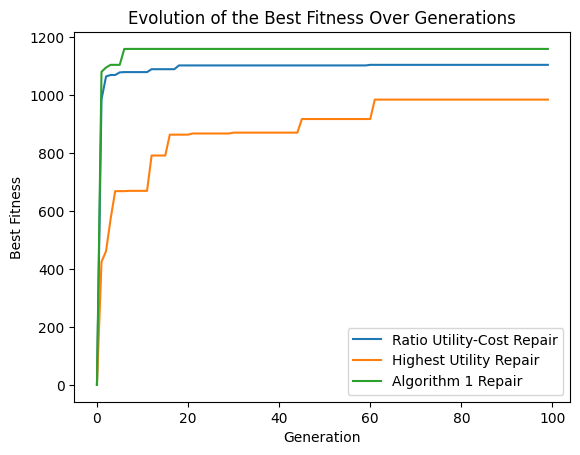

In [25]:
# Define parameters
np.random.seed(0)
population_size = 100
mutation_rate = 0.1
crossover_rate = 0.8
num_generations = 100
budgets = [200, 300, 250, 350, 400]
utilities = np.random.randint(10, 100, size=50)
costs = np.random.randint(1, 50, size=(50, 5))
elitism_rate = 0.2

# Initialize and run the genetic algorithm with ratio utility cost repair method
ga = GeneticAlgorithm(population_size, mutation_rate, crossover_rate, num_generations, budgets, utilities, costs, elitism_rate)
best_solution_ratio = ga.run('repair_ratio_utility_cost')
fitness_history_ratio = ga.best_fitness_history

# Initialize and run the genetic algorithm with highest utility repair method
ga = GeneticAlgorithm(population_size, mutation_rate, crossover_rate, num_generations, budgets, utilities, costs, elitism_rate)
best_solution_highest = ga.run('repair_highest_utility')
fitness_history_highest = ga.best_fitness_history

# Initialize and run the genetic algorithm with Algorithm 1 repair method
ga = GeneticAlgorithm(population_size, mutation_rate, crossover_rate, num_generations, budgets, utilities, costs, elitism_rate)
best_solution_algorithm_1 = ga.run('repair_algorithm_1')
fitness_history_algorithm_1 = ga.best_fitness_history

# Plot the evolution of the best fitness over generations for both repair methods
plt.plot(fitness_history_ratio, label='Ratio Utility-Cost Repair')
plt.plot(fitness_history_highest, label='Highest Utility Repair')
plt.plot(fitness_history_algorithm_1, label='Algorithm 1 Repair')

plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Evolution of the Best Fitness Over Generations')
plt.legend()
plt.show()


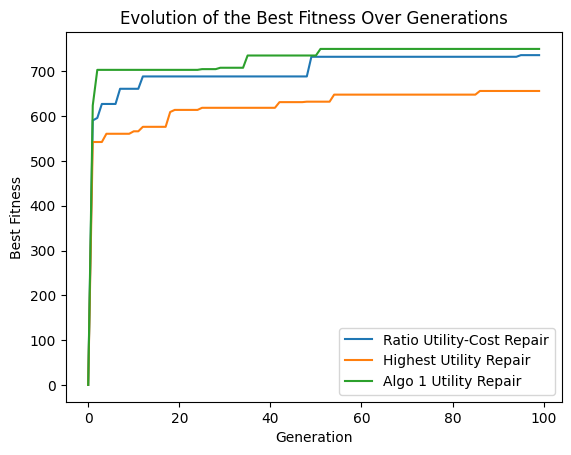

In [26]:
# Define parameters
np.random.seed(0)
population_size = 100
mutation_rate = 0.1
crossover_rate = 0.8
num_generations = 100
budgets = [200, 300, 250, 350, 400]

# Generate utilities and costs such that higher utility values are associated with higher costs
utilities = np.linspace(10, 100, 50)
costs = np.random.rand(50, 5) * utilities[:, np.newaxis]

elitism_rate = 0.2

# Initialize and run the genetic algorithm with ratio utility cost repair method
ga = GeneticAlgorithm(population_size, mutation_rate, crossover_rate, num_generations, budgets, utilities, costs, elitism_rate)
best_solution_ratio = ga.run('repair_ratio_utility_cost')
fitness_history_ratio = ga.best_fitness_history

# Initialize and run the genetic algorithm with highest utility repair method
ga = GeneticAlgorithm(population_size, mutation_rate, crossover_rate, num_generations, budgets, utilities, costs, elitism_rate)
best_solution_highest = ga.run('repair_highest_utility')
fitness_history_highest = ga.best_fitness_history

# Initialize and run the genetic algorithm with Algorithm 1 repair method
ga = GeneticAlgorithm(population_size, mutation_rate, crossover_rate, num_generations, budgets, utilities, costs, elitism_rate)
best_solution_algorithm_1 = ga.run('repair_algorithm_1')
fitness_history_algorithm_1 = ga.best_fitness_history

# Plot the evolution of the best fitness over generations for both repair methods
plt.plot(fitness_history_ratio, label='Ratio Utility-Cost Repair')
plt.plot(fitness_history_highest, label='Highest Utility Repair')
plt.plot(fitness_history_algorithm_1, label='Algo 1 Utility Repair')

plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Evolution of the Best Fitness Over Generations')
plt.legend()
plt.show()

## Same utilities, different costs

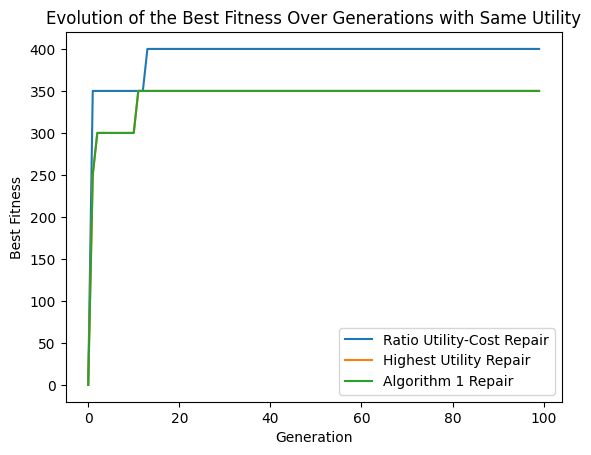

In [27]:
# Define parameters
np.random.seed(0)
population_size = 100
mutation_rate = 0.1
crossover_rate = 0.8
num_generations = 100
budgets = [200, 300, 250, 350, 400]

# Generate utilities with the same value for all objects
utilities = np.ones(50) * 50

# Generate random costs for each object in various dimensions
costs = np.random.rand(50, 5) * 100

elitism_rate = 0.2

# Initialize and run the genetic algorithm with ratio utility cost repair method
ga = GeneticAlgorithm(population_size, mutation_rate, crossover_rate, num_generations, budgets, utilities, costs, elitism_rate)
best_solution_ratio = ga.run('repair_ratio_utility_cost')
fitness_history_ratio = ga.best_fitness_history

# Initialize and run the genetic algorithm with highest utility repair method
ga = GeneticAlgorithm(population_size, mutation_rate, crossover_rate, num_generations, budgets, utilities, costs, elitism_rate)
best_solution_highest = ga.run('repair_highest_utility')
fitness_history_highest = ga.best_fitness_history

# Initialize and run the genetic algorithm with Algorithm 1 repair method
ga = GeneticAlgorithm(population_size, mutation_rate, crossover_rate, num_generations, budgets, utilities, costs, elitism_rate)
best_solution_algorithm_1 = ga.run('repair_algorithm_1')
fitness_history_algorithm_1 = ga.best_fitness_history

# Plot the evolution of the best fitness over generations for all repair methods
plt.plot(fitness_history_ratio, label='Ratio Utility-Cost Repair')
plt.plot(fitness_history_highest, label='Highest Utility Repair')
plt.plot(fitness_history_algorithm_1, label='Algorithm 1 Repair')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Evolution of the Best Fitness Over Generations with Same Utility')
plt.legend()
plt.show()
